In [1]:
import gc;
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, models
from keras.utils.test_utils import get_test_data
from skimage.morphology import binary_opening
from skimage.segmentation import mark_boundaries
from skimage.util import montage

from config import IMG_SCALING, TRAIN_DIR, CHECKPOINTS_DIR, TEST_DIR, INPUT_DIR
from prepare_datasets import load_dataset, drop_empty_images, split_validation_dataset, get_train_val_datasets, \
    get_unique_img_ids
from utils.data_utils import make_image_gen
from utils.rle_utils import rle_encode, multi_rle_encode, masks_as_color, masks_as_image

gc.enable()  # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

print(os.listdir("input"))


Using TensorFlow backend.


['test_ship_segmentations.csv', 'sample_submission.csv', 'train_ship_segmentations.csv', 'test', 'train']
['test_ship_segmentations.csv', 'sample_submission.csv', 'train_ship_segmentations.csv', 'test', 'train']


In [2]:
df = load_dataset()
df.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


# 1. Training dataset stats

In [3]:
# 1. Use only image with ships
# 2. Pretrained U-net CNN model, ResNet, Ternaus on ImageNet
# 3. Try to learn on 768x768 images


# TODO:
# 1. Check results
# 2. Crete repo for models and learning them by scripts with notbooks only to visualization and predicting

In [4]:
num_of_all_images = len(df.drop_duplicates('ImageId'))
num_of_no_ships_images = sum(pd.isnull(df['EncodedPixels']))
num_of_all_rows = len(df)

print("Number of images: {}".format(num_of_all_images))
print("Number of images without ships: {}".format(num_of_no_ships_images))
print("Number of images with ships: {}".format(num_of_all_images - num_of_no_ships_images))
print("Number of ships: {}".format(num_of_all_rows - num_of_no_ships_images))

# We can consider that dataset is not balanced enough, let's remove empty images.

Number of images: 104070
Number of images without ships: 75000
Number of images with ships: 29070
Number of ships: 56030


# 2. RLE encoding and decoding

## Check if above functions work properly

In [5]:
df.loc[df['ImageId'] =="00021ddc3.jpg"]

,ImageId,EncodedPixels
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...
6,00021ddc3.jpg,139644 2 140408 6 141174 9 141942 9 142711 6 1...
7,00021ddc3.jpg,86727 2 87493 4 88261 4 89030 3 89798 4 90566 ...
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9,00021ddc3.jpg,75972 3 76738 5 77506 5 78274 5 79042 6 79811 ...
10,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


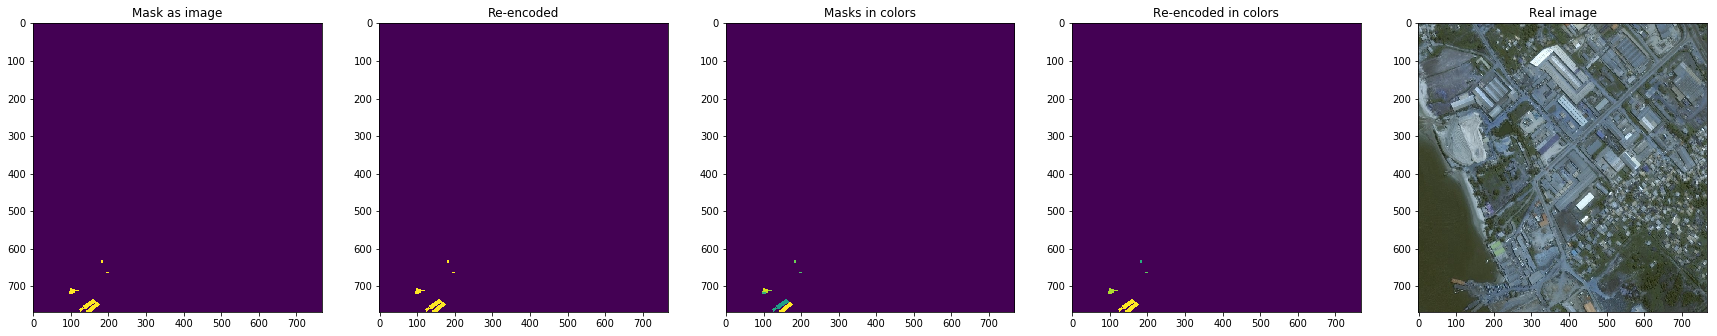

In [6]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (30, 10))
rle_0 = df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_2 = masks_as_color(rle_0)
ax3.imshow(img_2)
ax3.set_title('Masks in colors')
img_3 = masks_as_color(rle_1)
ax4.imshow(img_3)
ax4.set_title('Re-encoded in colors')

img_4 = cv2.imread(os.path.join(TRAIN_DIR, '00021ddc3.jpg'))
ax5.imshow(img_4)
ax5.set_title('Real image')


print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

# 3. Split to taining and validation datasets

,ImageId,ships,has_ship,file_size_kb
84829,d0e68fef4.jpg,0,0.0,202.882812
64833,9f61f8df1.jpg,0,0.0,137.950195
94355,e82d9953f.jpg,1,1.0,342.623047
63861,9cdc4000e.jpg,0,0.0,146.516602
20390,3214c86c7.jpg,0,0.0,134.470703
11958,1d2c43b25.jpg,0,0.0,168.742188
98190,f1810210a.jpg,2,1.0,155.985352


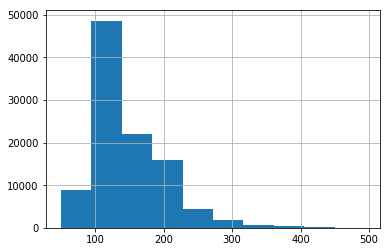

In [7]:
unique_img_ids = get_unique_img_ids(df)

unique_img_ids['file_size_kb'].hist()
unique_img_ids.sample(7)


## Ships number histogram

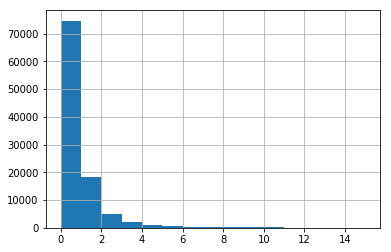

In [8]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Drop empty images

28693 masks


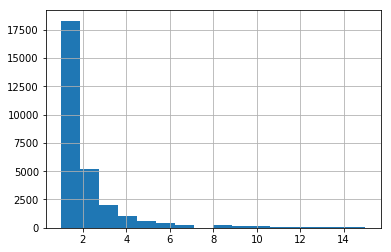

In [9]:
balanced_train_df = drop_empty_images(unique_img_ids)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')



In [10]:
train_df, valid_df = get_train_val_datasets(df, balanced_train_df)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head()

17645 training masks
637 validation masks


,ImageId,EncodedPixels,ships,has_ship,file_size_kb
0,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1,1.0,232.898438
1,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,1,1.0,197.588867
2,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,1,1.0,305.848633
3,000d42241.jpg,369226 3 369992 5 370760 5 371528 5 372296 5 3...,1,1.0,65.922852
4,000e6378b.jpg,224667 2 225431 6 226196 10 226962 12 227730 1...,1,1.0,181.113281


## Create validation dataset

In [11]:
valid_x, valid_y = split_validation_dataset(valid_df)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (1000, 384, 384, 3) 0.0 1.0
y (1000, 384, 384, 1) 0 1


Text(0.5,1,'Outlined Ships')

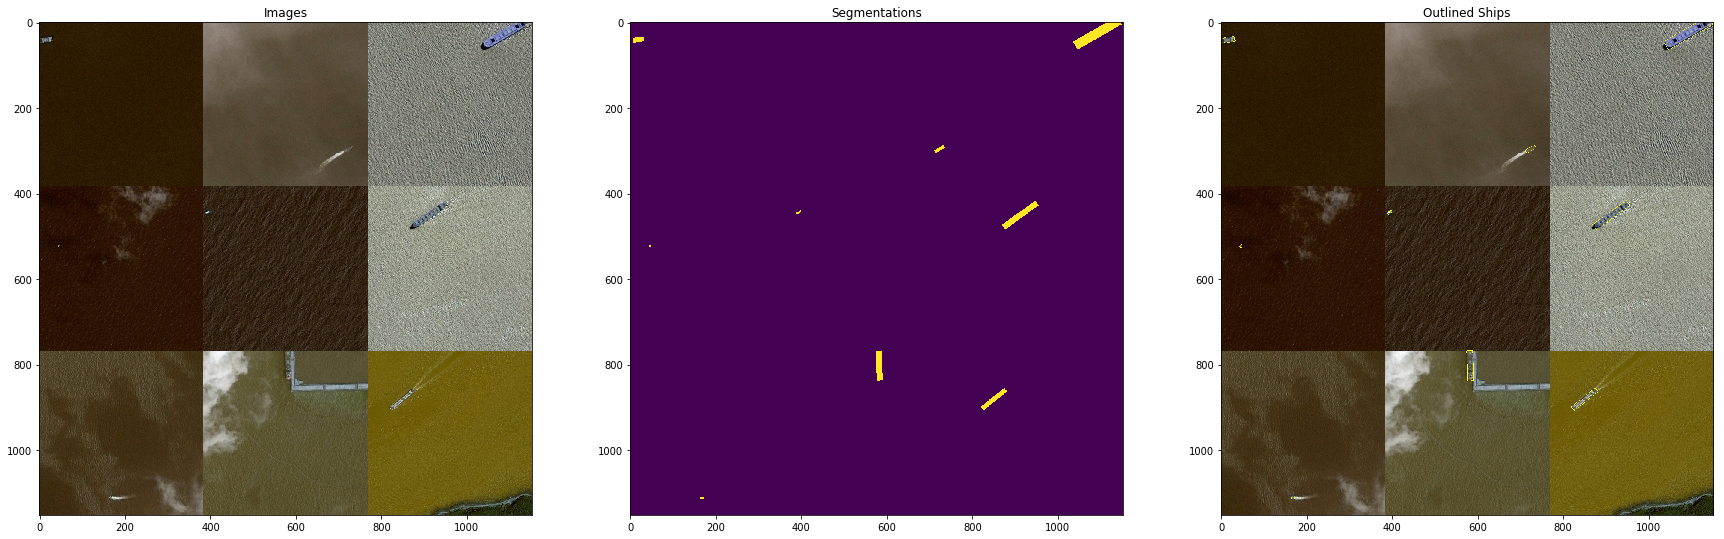

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(valid_x[:9])
batch_seg = montage(valid_y[:9, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')


In [13]:
gc.collect()

5

# 4. Model (run after fiting outside notebook)

In [17]:
from models import UNet
seg_model = UNet()
keras_model = seg_model.get_model()
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 384, 384, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 384, 384, 3)  0           average_pooling2d_2[0][0]        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 384, 384, 3)  12          gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_20 

In [18]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')


loss_history = pd.read_csv(seg_model.FIT_HISTORY_PATH)
show_loss(loss_history)

FileNotFoundError: File b'checkpoints/_history.csv' does not exist

In [ ]:
keras_model.load_weights(seg_model.WEIGHT_PATH)
keras_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(seg_model.MODEL_NAME)))

In [ ]:
pred_y = keras_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(keras_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = keras_model
fullres_model.save(os.path.join(CHECKPOINTS_DIR, '{}.h5'.format(seg_model.FULL_RES_MODEL_NAME)))


In [ ]:
def predict(c_img_name, path=TEST_DIR, thresh=0.5):
    c_img = cv2.imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg[cur_seg > thresh] = 1
    cur_seg[cur_seg < thresh] = 0
    return cur_seg, c_img


## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = predict(c_img_name, TRAIN_DIR)
    ax1.imshow(first_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0])
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(first_seg[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Re-encoded')
    ground_truth = masks_as_color(df.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
  
    
    
# fig.savefig('validation.png')

# 5. SUBMISSION

In [ ]:
test_paths = np.array(os.listdir(TEST_DIR))
print(len(test_paths), 'test images found')


In [ ]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:30000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

In [ ]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

In [ ]:
## let's see what we got
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = cv2.imread(os.path.join(TEST_DIR, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [ ]:
sub1 = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

